# Summery

- 시계열 데이터의 경우 여러 개의 파형으로 이루어진 하나의 복합 데이터라고 할 수 있음

- 그러므로 본 과제에서 가장 중요한 것은 시계열 데이터를 여러 파형으로 분리하면서, 시간적 특성을 반영할 수 있는 모델을 만드는 것이 중요하다고 생각함

- 따라서 퓨리에 변환을 이용하여 시계열 데이터 속에 주파수 패턴을 바탕으로 중요한 특징을 추출하고,Transformer-Encoder-LSTM 모델을 이용하여 시간적 특성을 반영하는 모델을 생성함

- 시간적 특성을 반영하는 모델로는 CNN1D 등도 존재하지만, 본 데이터의 경우 dataset0과 dataset1의 Seq-Length가 달라 CNN의 feature-map 계산에 어려움이 존재하기 때문에, Transformer-Encoder외 LSTM을 사용함

## 피쳐 엔지니어링
- 주어진 자이로스코프와 가속도계를 사용하여 수집한 6종의 변수를 퓨리에 변환을 적용한 후 사용

- 퓨리에 변환 적용 전 리더보드 상 점수 4.1111

- 퓨리에 변환 적용 후 리더보드 상 점수 7.2321

- 따라서 퓨리에 변환을 적용한 변수를 사용하는 것이 더 좋다는 것을 알 수 있음

## 모델
- 기본적인 모델 구조는 Transformer-Encoder, LSTM, FC-Layer로 이루어짐

- 시계열 데이터의 경우 시간에 대한 인과성을 표현하는 것이 중요하다고 생각하여, Transformer-Encoder를 사용하여 각 Time-Step 마다 시간에 대한 인과성을 학습하여 Seq-Embedding을 생성함

- 데이터마다 Seq-Length가 다르기 때문에 단순히 Seq-Embedding을 FC-Layer에 넣는 것은 어렵다고 판단하여, LSTM을 사용하여 Seq-Embedding에 반영된 시간적 특성을 모두 담은 Seq-Embedding을 생성하고, 마지막 Time-Step에 해당하는 Seq-Embedding을 FC-Layer에 input으로 사용

- Transformer-Encoder 덕분에 데이터 마다 Seq-Length가 달라도 Seq-Embedding을 생성할 수 있음

- Transformer-Encoder의 masking과 Attention을 이용하여 시간에 대한 인과성을 학습할 수 있음

- LSTM 덕분에 데이터마다 Seq-Length가 달라도 FC-Layer의 input을 생성할 수 있음(전체 Time-Step에 대한 특성이 반영된 하나의 Seq-Embedding을 생성할 수 있음)

- dataset0으로 모델의 Weight를 학습하고, dataset1에 대한 전이 학습시 FC-Layer만 교체하여 학습을 진행함

- 모든 데이터를 단순히 해당 데이터의 max-Length로 변경하면 불필요한 연산이 증가하기 때문에, 배치 마다의 max-Length를 구해 배치마다 다른 padding을 적용함

- 학습 도중 오버 슛팅 현상이 발생하여 스케줄러를 적용하려 했지만, 불규칙적이다는 것을 확인하여 lr을 작게하여 모델을 학습시킴

- Out-of-Fold Ensemble을 적용하여 조금더 일반화된 결과를 얻음

## TODO
- 주어진 데이터를 사용한 모델 성능 평가 상으로는 (t + 1) - t 를 이용하여 구한 diff 변수(변화량)를 추가하는 것이 더 높음, 그러나 본 변수를 사용하면 리더보드 상에서는 더 점수가 낮아짐
  - dataset1의 경우 데어터의 수가 적어 과적합이 발생한 것으로 생각됨

- Out-of-Fold Ensemble을 적용하면, 모델의 분산이 낮아져 조금 더 일반화된 결과를 얻을 수 있음, 그러나 본 대회의 경우 Out-of-Fold Ensemble 적용시 리더보드 상에서는 더 점수가 낮아짐
  - dataset1과 리더보드 데이터 간의 분포의 차이가 존재한다고 생각하여, 데이터 분리를 조금 더 제대로 해야된다고 생각됨(Seq-Length도 고려하여 데이터 셋을 분리하였지만 해결책은 아니었음)

In [1]:
import os
import math
import random
import pandas as pd
import numpy as np
from scipy import fftpack

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, confusion_matrix

import warnings

warnings.filterwarnings(action='ignore')

# 기타 함수

In [2]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [3]:
def show_class_count_check(df, ax):
    sns.countplot(df['class'], ax = ax)

def show_data_sequence_length_check(df, ax):
    sns.histplot(df['length'], ax = ax)

In [4]:
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_true, y_pred):
    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_pred))
    display(confusion_matrix_df.style.background_gradient(cmap='YlOrRd', axis = 1))

In [5]:
def show_train_imgae(train_loss_list, test_loss_list, train_fi_list, test_fi_list,config):
    
    plt.figure(figsize = (15, 8))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, config.epochs + 1), train_loss_list, label = 'train')
    plt.plot(range(1, config.epochs + 1), test_loss_list, label = 'test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title(f'Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, config.epochs + 1), train_fi_list, label = 'train')
    plt.plot(range(1, config.epochs + 1), test_fi_list, label = 'test')
    plt.ylabel('F1-Score')
    plt.xlabel('Epoch')
    plt.title(f'F1-Score')
    plt.legend()

    plt.show()

# 전처리 함수

In [6]:
def make_dataset_df(dataset_dir, data_dir):
    df = []
    dir = os.path.join(dataset_dir, data_dir)
    class_dir_list = os.listdir(dir)
    for class_dir in class_dir_list:
        _class = class_dir
        class_dir = os.path.join(dir, class_dir)
        data_dir_list = os.listdir(class_dir)
        for data_dir in data_dir_list:
            data_dir = os.path.join(class_dir, data_dir)
            df.append({
                'data_dir' : data_dir,
                'class' : int(_class[len('class'):]),
                'length' : pd.read_csv(data_dir).values.shape[0],
            })
    
    return pd.DataFrame(df)


def make_dataset1_test_df(dataset_dir, data_dir):
    df = []
    dir = os.path.join(dataset_dir, data_dir)
    data_dir_list = os.listdir(dir)
    for data_dir in data_dir_list:
        index = data_dir.split('.csv')[0]
        data_dir = os.path.join(dir, data_dir)
        df.append({
                'index' : int(index),
                'data_dir' : data_dir,
                'class' : 0,
                'length' : pd.read_csv(data_dir).values.shape[0],
            })
    
    return pd.DataFrame(df).sort_values('index').reset_index(drop = True)

In [7]:
def fourier_transform(x):
    complex_f_signal= fftpack.fft(x, axis = 0)
    amplitude_f_signal=np.abs(complex_f_signal)
    return amplitude_f_signal

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        df = self.df.iloc[idx, :]
        
        data_dir = df['data_dir']
        data_class = df['class']

        # data = fourier_transform(pd.read_csv(data_dir).values)

        fourier_transform_data = fourier_transform(pd.read_csv(data_dir).values)
        diff_data = fourier_transform_data[1:, :] - fourier_transform_data[:-1, :]
        diff_data = np.concatenate([np.zeros((1, diff_data.shape[1])), diff_data], axis = 0)

        data = np.concatenate([fourier_transform_data, diff_data], axis = 1)

        return {'data' : data, 'label' : data_class}


def make_padding_sequence(seq, max_len, padding_value = 0):
    try:
        seq_len, col = seq.shape
        padding = np.zeros((max_len - seq_len, col)) + padding_value
    except:
        seq_len = seq.shape[0]
        padding = np.zeros((max_len - seq_len, )) + padding_value

    padding_seq = np.concatenate([padding, seq])

    return padding_seq


def make_collate_fn(samples):
    max_len = 0
    for sample in samples:
        seq_len, col = sample['data'].shape
        if max_len < seq_len:
            max_len = seq_len

    masks = []
    datas = []
    labels = []

    for sample in samples:
        mask = np.ones(sample['data'].shape[0])

        masks += [make_padding_sequence(mask, max_len = max_len, padding_value = 0)]
        datas += [make_padding_sequence(sample['data'], max_len = max_len, padding_value = 0)]
        labels += [sample['label']]
    
    return {
        'masks' : torch.tensor(masks, dtype = torch.long), 
        'datas' : torch.tensor(datas, dtype = torch.float32), 
        'labels' : torch.tensor(labels, dtype = torch.long),
        }

# 모델 : TrasformerEncoderLSTM

In [8]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.hidden_units = hidden_units
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, Q, K, V, mask):
        """
        Q, K, V : (batch_size, num_heads, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        """
        attn_score = torch.matmul(Q, K.transpose(2, 3)) / math.sqrt(self.hidden_units) # (batch_size, num_heads, max_len, max_len)
        attn_score = attn_score.masked_fill(mask == 0, -1e9)  # 유사도가 0인 지점은 -infinity로 보내 softmax 결과가 0이 되도록 함
        attn_dist = self.dropout(F.softmax(attn_score, dim=-1))  # attention distribution
        output = torch.matmul(attn_dist, V)  # (batch_size, num_heads, max_len, hidden_units) / # dim of output : batchSize x num_head x seqLen x hidden_units
        return output, attn_dist


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.hidden_units = hidden_units
        
        self.W_Q = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_K = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_V = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_O = nn.Linear(hidden_units, hidden_units, bias=False)

        self.attention = ScaledDotProductAttention(hidden_units, dropout_rate)
        self.dropout = nn.Dropout(dropout_rate) # dropout rate
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, enc, mask):
        """
        enc : (batch_size, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        
        """
        residual = enc
        batch_size, seqlen = enc.size(0), enc.size(1)

        Q = self.W_Q(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units // self.num_heads) # (batch_size, max_len, num_heads, hidden_units)
        K = self.W_K(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units // self.num_heads) # (batch_size, max_len, num_heads, hidden_units)
        V = self.W_V(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units // self.num_heads) # (batch_size, max_len, num_heads, hidden_units)

        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2) # (batch_size, num_heads, max_len, hidden_units)
        output, attn_dist = self.attention(Q, K, V, mask) # output : (batch_size, num_heads, max_len, hidden_units) / attn_dist : (batch_size, num_heads, max_len, max_len)

        output = output.transpose(1, 2).contiguous() # (batch_size, max_len, num_heads, hidden_units) / contiguous() : 가변적 메모리 할당
        output = output.view(batch_size, seqlen, -1) # (batch_size, max_len, hidden_units * num_heads)

        output = self.layerNorm(self.dropout(self.W_O(output)) + residual) # (batch_size, max_len, hidden_units)
        return output, attn_dist


class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PositionwiseFeedForward, self).__init__()

        self.W_1 = nn.Linear(hidden_units, hidden_units)
        self.W_2 = nn.Linear(hidden_units, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, x):
        residual = x
        output = self.W_2(F.relu(self.dropout(self.W_1(x))))
        output = self.layerNorm(self.dropout(output) + residual)
        return output


class Block(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(Block, self).__init__()
        self.attention = MultiHeadAttention(num_heads, hidden_units, dropout_rate)
        self.pointwise_feedforward = PositionwiseFeedForward(hidden_units, dropout_rate)

    def forward(self, input_enc, mask):
        """
        input_enc : (batch_size, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        """
        output_enc, attn_dist = self.attention(input_enc, mask)
        output_enc = self.pointwise_feedforward(output_enc)
        return output_enc, attn_dist


class TrasformerEncoderLSTM(nn.Module):
    def __init__(self, num_cols, num_labels, hidden_units, num_heads, num_layers, dropout_rate):
        super(TrasformerEncoderLSTM, self).__init__()

        self.embedding = nn.Sequential(
            nn.Linear(num_cols, hidden_units),
            nn.LayerNorm(hidden_units, eps=1e-6)
        )
        
        self.blocks = nn.ModuleList([Block(num_heads, hidden_units, dropout_rate) for _ in range(num_layers)])
        
        self.lstm = nn.LSTM(
            input_size = hidden_units,
            hidden_size = hidden_units,
            num_layers = num_layers,
            batch_first = True,
            bidirectional = False,
            dropout = dropout_rate,
            )
        
        self.fc = nn.Linear(hidden_units, num_labels)
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    
    def forward(self, input):
        """
        input = {
            'masks' : (batch_size, max_len)
            'datas' : (batch_size, max_len, num_cols)
            'labels' : (batch_size)
        }
        """

        mask = input['masks']
        data = input['datas']

        # masking
        mask_pad = torch.BoolTensor(mask > 0).unsqueeze(1).unsqueeze(1) # (batch_size, 1, 1, max_len)
        mask_time = (1 - torch.triu(torch.ones((1, 1, mask.size(1), mask.size(1))), diagonal=1)).bool() # (batch_size, 1, max_len, max_len)
        mask = (mask_pad & mask_time).to(self.device) # (batch_size, 1, max_len, max_len)

        # Transformer-Encoder
        embedding = self.embedding(data.to(self.device))
        for block in self.blocks:
            embedding, attn_dist = block(embedding, mask)

        # LSTM
        embedding, _ = self.lstm(embedding)

        # FC
        output = self.fc(embedding[:, -1])

        return output

# 학습 함수

In [9]:
def train(model, data_loader, criterion, optimizer, config):
    model.train()

    loss_val = 0
    f1 = 0

    y_true = []
    y_pred = []

    for input in data_loader:

        optimizer.zero_grad()

        output = model(input)
        loss = criterion(output, input['labels'].to(config.device))

        loss.backward()
        optimizer.step()

        loss_val += loss.item()

        y_true += input['labels'].cpu().numpy().tolist()
        y_pred += output.argmax(dim = 1).detach().cpu().numpy().tolist()

    loss_val /= len(data_loader)
    f1 += f1_score(y_true, y_pred, average='macro')

    return loss_val, f1


def evaluate(model, data_loader, criterion, config):
    model.eval()

    loss_val = 0
    f1 = 0

    y_true = []
    y_pred = []

    with torch.no_grad():
        for input in data_loader:

            output = model(input)
            loss = criterion(output, input['labels'].to(config.device))
            loss_val += loss.item()

            y_true += input['labels'].cpu().numpy().tolist()
            y_pred += output.argmax(dim = 1).cpu().numpy().tolist()

    loss_val /= len(data_loader)
    f1 += f1_score(y_true, y_pred, average='macro')

    return loss_val, f1


def predict(model, data_loader):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for input in data_loader:
            output = model(input)
            y_pred += output.argmax(dim = 1).cpu().numpy().tolist()
    
    return y_pred


def oof_predict(model, data_loader):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for input in data_loader:
            output = model(input)
            y_pred.append(output.softmax(dim = 1).cpu().numpy())
    
    return np.concatenate(y_pred)

# 학습 설정

In [10]:
class Config:
    
    oof = 5
    num_cols = 12
    
    dataset0_num_labels = 15
    dataset1_num_labels = 11

    dataset0_dir = './dataset0/'
    dataset1_dir = './dataset1/'

    train_dir = 'train/'
    test_dir ='test/'

    model_dir = './model'
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)

    dataset0_model_name = 'dataset0-model-v5'
    dataset1_model_name = 'dataset1-model-v8'

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_heads = 4
    hidden_units = 64
    num_layers = 1
    dropout_rate = 0.5
    batch_size = 128
    num_workers = 8
    lr = 0.0005
    epochs = 50

    submission_file_name = f'{num_heads}-{hidden_units}-{num_layers}-{batch_size}-{dataset1_model_name}-submission'

config = Config

# 데이터 로드

In [11]:
dataset0_train_df = make_dataset_df(config.dataset0_dir, config.train_dir)
dataset0_test_df = make_dataset_df(config.dataset0_dir, config.test_dir)

dataset1_train_df = make_dataset_df(config.dataset1_dir, config.train_dir)
dataset1_test_df = make_dataset1_test_df(config.dataset1_dir, config.test_dir)

# EDA

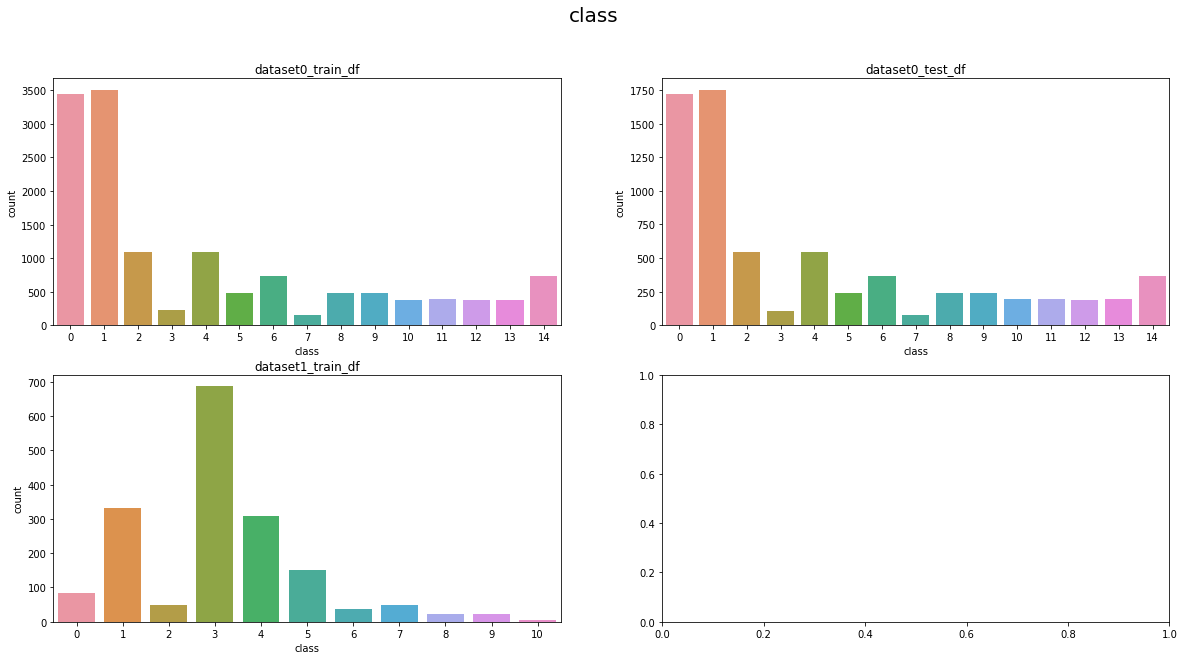

In [12]:
fig, axes = plt.subplots(2, 2, figsize = (20, 10))

axes[0][0].set_title('dataset0_train_df')
show_class_count_check(df = dataset0_train_df, ax = axes[0][0])

axes[0][1].set_title('dataset0_test_df')
show_class_count_check(df = dataset0_test_df, ax = axes[0][1])

axes[1][0].set_title('dataset1_train_df')
show_class_count_check(df = dataset1_train_df, ax = axes[1][0])

fig.suptitle('class', fontsize = 20)
fig.show()

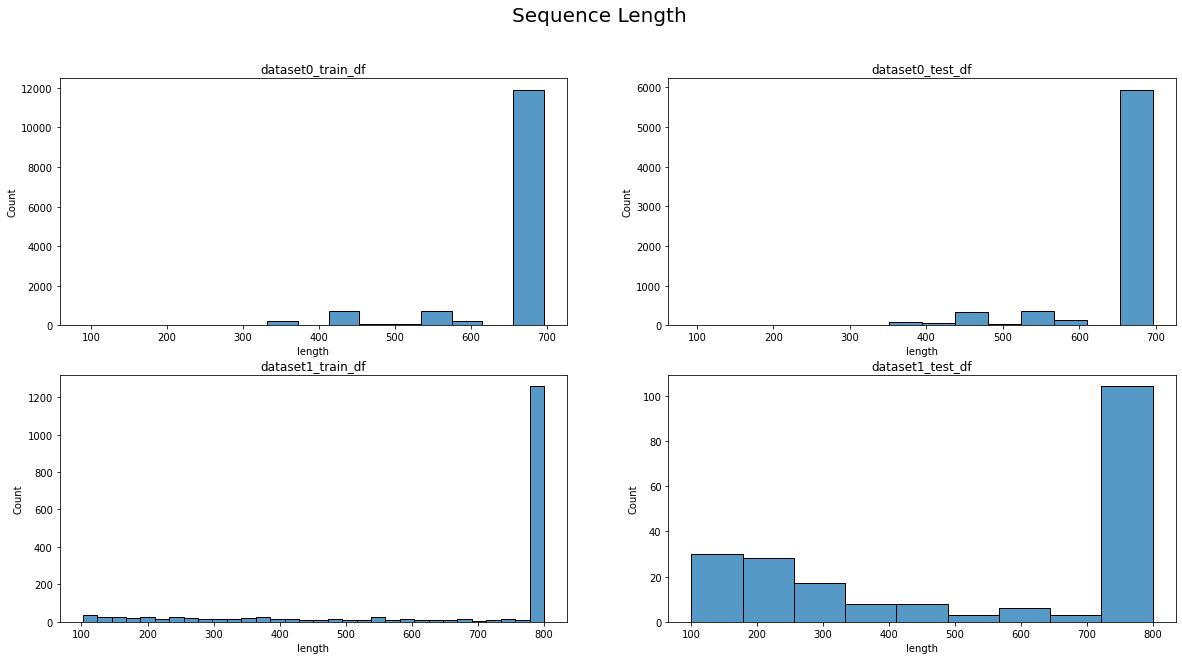

In [13]:
fig, axes = plt.subplots(2, 2, figsize = (20, 10))

axes[0][0].set_title('dataset0_train_df')
show_data_sequence_length_check(df = dataset0_train_df, ax = axes[0][0])

axes[0][1].set_title('dataset0_test_df')
show_data_sequence_length_check(df = dataset0_test_df, ax = axes[0][1])

axes[1][0].set_title('dataset1_train_df')
show_data_sequence_length_check(df = dataset1_train_df, ax = axes[1][0])

axes[1][1].set_title('dataset1_test_df')
show_data_sequence_length_check(df = dataset1_test_df, ax = axes[1][1])

fig.suptitle('Sequence Length', fontsize = 20)
fig.show()

# dataset0 학습

In [14]:
seed_everything(22)

In [15]:
dataset0_train_df_dataset = CustomDataset(dataset0_train_df)
dataset0_train_df_data_loader = DataLoader(
        dataset0_train_df_dataset,
        batch_size = config.batch_size,
        shuffle = True, 
        drop_last = False,
        collate_fn = make_collate_fn,
        num_workers = config.num_workers)


dataset0_test_df_dataset = CustomDataset(dataset0_test_df)
dataset0_test_df_data_loader = DataLoader(
        dataset0_test_df_dataset,
        batch_size = config.batch_size,
        shuffle = False, 
        drop_last = False,
        collate_fn = make_collate_fn,
        num_workers = config.num_workers)

In [16]:
model = TrasformerEncoderLSTM(
    num_cols = config.num_cols, 
    num_labels = config.dataset0_num_labels, 
    hidden_units = config.hidden_units, 
    num_heads = config.num_heads, 
    num_layers = config.num_layers, 
    dropout_rate = config.dropout_rate,
    ).to(config.device)

optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
criterion = nn.CrossEntropyLoss()

In [17]:
best_test_fi = 0

train_loss_list, test_loss_list, train_fi_list, test_fi_list = [], [], [], []
for epoch in range(1, config.epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
            train_loss, train_fi = train(model, dataset0_train_df_data_loader, criterion, optimizer, config)
            test_loss, test_fi = evaluate(model, dataset0_test_df_data_loader, criterion, config)

            train_loss_list += [train_loss]
            train_fi_list += [train_fi]

            test_loss_list += [test_loss]
            test_fi_list += [test_fi]

            if best_test_fi < test_fi:
                best_epoch, best_train_loss, best_train_fi, best_test_loss, best_test_fi = epoch, train_loss, train_fi, test_loss, test_fi
                torch.save(model.state_dict(), os.path.join(config.model_dir, config.dataset0_model_name + '.pt'))

            tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| Train F1: {train_fi:.5f}| Test loss: {test_loss:.5f}| Test F1: {test_fi:.5f}')
    
print(f'BEST | Epoch: {best_epoch:3d}| Train loss: {best_train_loss:.5f}| Train F1: {best_train_fi:.5f}| Test loss: {best_test_loss:.5f}| Test F1: {best_test_fi:.5f}')

Epoch:   1| Train loss: 1.78396| Train F1: 0.13562| Test loss: 1.32967| Test F1: 0.22609: 100%|██████████| 1/1 [00:34<00:00, 34.27s/it]
Epoch:   2| Train loss: 1.13499| Train F1: 0.28784| Test loss: 1.05128| Test F1: 0.32276: 100%|██████████| 1/1 [00:35<00:00, 35.42s/it]
Epoch:   3| Train loss: 0.93192| Train F1: 0.37741| Test loss: 0.95994| Test F1: 0.38282: 100%|██████████| 1/1 [00:34<00:00, 34.86s/it]
Epoch:   4| Train loss: 0.82848| Train F1: 0.42984| Test loss: 0.88783| Test F1: 0.42442: 100%|██████████| 1/1 [00:35<00:00, 35.03s/it]
Epoch:   5| Train loss: 0.75844| Train F1: 0.47664| Test loss: 0.84067| Test F1: 0.44756: 100%|██████████| 1/1 [00:35<00:00, 35.15s/it]
Epoch:   6| Train loss: 0.68146| Train F1: 0.51104| Test loss: 0.91404| Test F1: 0.44085: 100%|██████████| 1/1 [00:34<00:00, 34.95s/it]
Epoch:   7| Train loss: 0.61262| Train F1: 0.54518| Test loss: 1.04831| Test F1: 0.45088: 100%|██████████| 1/1 [00:33<00:00, 33.94s/it]
Epoch:   8| Train loss: 0.56047| Train F1: 0.596

BEST | Epoch:   9| Train loss: 0.53067| Train F1: 0.61334| Test loss: 0.76651| Test F1: 0.55134


```
BEST | Epoch:  29| Train loss: 0.82312| Train F1: 0.46811| Test loss: 1.00971| Test F1: 0.44296 - non 퓨리에 변환

BEST | Epoch:  16| Train loss: 0.49898| Train F1: 0.65251| Test loss: 0.76507| Test F1: 0.55053 - add 퓨리에 변환

BEST | Epoch:   9| Train loss: 0.53067| Train F1: 0.61334| Test loss: 0.76651| Test F1: 0.55134 - add 퓨리에 변환

BEST | Epoch:  39| Train loss: 0.14955| Train F1: 0.86987| Test loss: 0.43314| Test F1: 0.73602 - add 퓨리에 변환 / diff 변수 

```

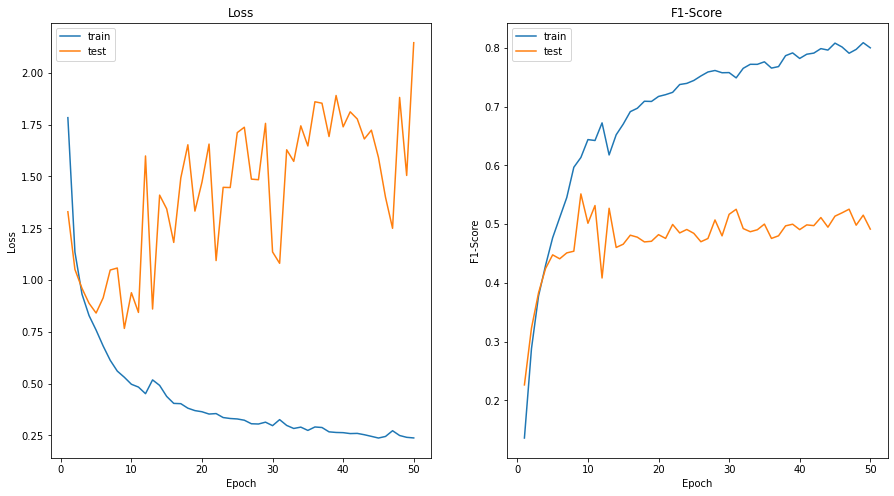

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1389,0,0,10,0,11,19,99,18,7,5,10,2,151,2
1,1,1624,8,0,21,0,12,0,0,12,0,1,0,1,71
2,0,1,509,0,19,1,12,0,0,0,0,6,0,1,0
3,0,0,0,6,0,11,0,0,7,0,22,28,7,29,0
4,0,23,17,0,505,0,1,0,0,0,0,0,0,3,0
5,0,0,0,0,0,224,0,0,17,1,1,0,0,0,0
6,19,26,4,0,22,1,210,20,3,32,0,0,0,0,28
7,2,0,0,0,0,32,0,34,2,4,0,0,0,0,2
8,0,2,2,0,0,18,2,0,174,29,1,0,3,7,0
9,9,7,1,0,0,4,9,8,42,148,0,0,1,1,10


In [18]:
model = TrasformerEncoderLSTM(
    num_cols = config.num_cols, 
    num_labels = config.dataset0_num_labels, 
    hidden_units = config.hidden_units, 
    num_heads = config.num_heads, 
    num_layers = config.num_layers, 
    dropout_rate = config.dropout_rate,
    ).to(config.device)

model.load_state_dict(torch.load(os.path.join(config.model_dir, config.dataset0_model_name + '.pt')))

y_true = dataset0_test_df['class'].tolist()
y_pred = predict(model, dataset0_test_df_data_loader)

show_train_imgae(train_loss_list, test_loss_list, train_fi_list, test_fi_list, config)

show_confusion_matrix(y_true, y_pred)

# dataset1 학습

In [19]:
dataset1_train_df['length_cat'] = dataset1_train_df['length'] // 200
dataset1_train_df['split_val'] = dataset1_train_df['length_cat'].astype('str') + '-' + dataset1_train_df['class'].astype('str')

one_val_list = dataset1_train_df['split_val'].value_counts()[dataset1_train_df['split_val'].value_counts() <= 1].index.tolist()

dataset1_train_df['split_val'] = dataset1_train_df['split_val'].apply(lambda x : 'one_val' if x in one_val_list else x)

## Out-of-Fold Ensemble 적용 O

### 학습

OOF-0| Epoch:  10| Train loss: 0.91593| Train F1: 0.39055| Test loss: 0.89480| Test F1: 0.39729
OOF-0| Epoch:  20| Train loss: 0.61470| Train F1: 0.54063| Test loss: 0.60890| Test F1: 0.50041
OOF-0| Epoch:  30| Train loss: 0.64797| Train F1: 0.52742| Test loss: 0.60416| Test F1: 0.53948
OOF-0| Epoch:  40| Train loss: 0.36697| Train F1: 0.64123| Test loss: 0.41223| Test F1: 0.63169
OOF-0| Epoch:  50| Train loss: 0.30168| Train F1: 0.67576| Test loss: 0.37512| Test F1: 0.62458
BEST| OOF-0| Epoch:  43| Train loss: 0.36402| Train F1: 0.63232| Test loss: 0.39261| Test F1: 0.66039


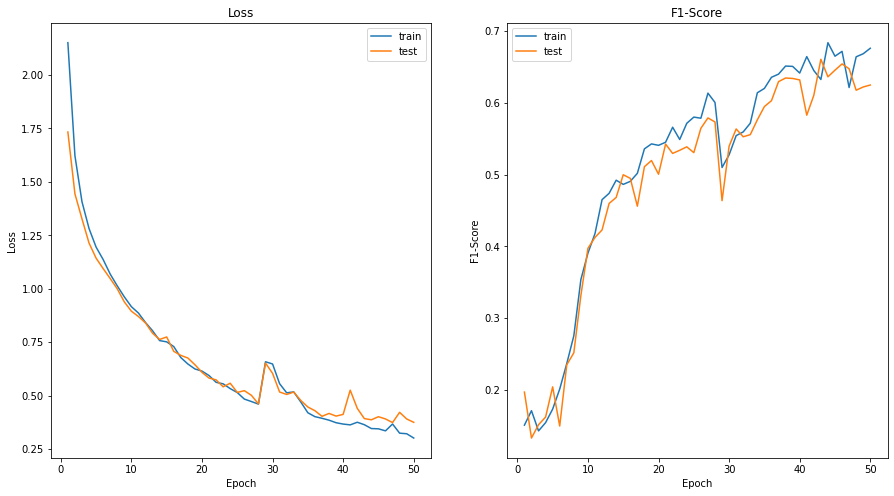

,0,1,2,3,4,5,6,7,8,9,10
0,17,0,0,0,0,0,0,0,0,0,0
1,0,63,0,3,0,0,0,0,0,0,0
2,3,0,6,0,0,0,0,0,0,0,0
3,0,1,0,130,6,1,0,0,0,0,0
4,0,0,0,5,52,3,0,1,0,0,0
5,0,0,0,2,2,26,0,0,0,0,0
6,1,1,0,0,0,0,5,0,0,0,0
7,0,1,0,0,1,0,1,7,0,0,0
8,0,0,0,0,0,0,1,4,0,0,0
9,0,0,0,2,0,0,0,0,0,3,0


OOF-1| Epoch:  10| Train loss: 0.91764| Train F1: 0.35912| Test loss: 0.91357| Test F1: 0.36640
OOF-1| Epoch:  20| Train loss: 0.58823| Train F1: 0.54008| Test loss: 0.64144| Test F1: 0.53254
OOF-1| Epoch:  30| Train loss: 0.39865| Train F1: 0.63850| Test loss: 0.49809| Test F1: 0.61401
OOF-1| Epoch:  40| Train loss: 0.30898| Train F1: 0.68413| Test loss: 0.45290| Test F1: 0.65596
OOF-1| Epoch:  50| Train loss: 0.28425| Train F1: 0.67212| Test loss: 0.42038| Test F1: 0.67339
BEST| OOF-1| Epoch:  50| Train loss: 0.28425| Train F1: 0.67212| Test loss: 0.42038| Test F1: 0.67339


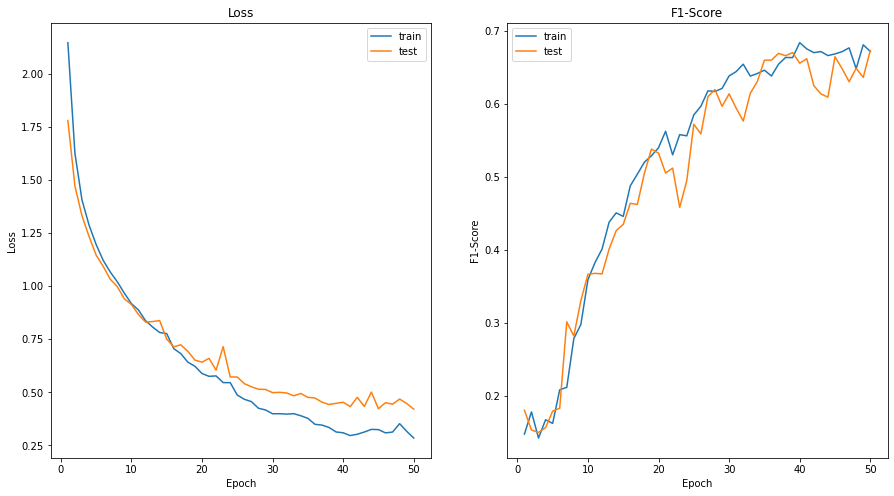

,0,1,2,3,4,5,6,7,8,9,10
0,17,0,0,0,0,0,0,0,0,0,0
1,0,63,0,1,0,0,0,0,0,2,0
2,1,0,8,0,0,0,1,0,0,0,0
3,0,0,0,125,12,0,0,0,0,0,0
4,0,0,0,8,52,1,0,0,0,0,0
5,0,0,0,1,3,27,0,0,0,0,0
6,0,0,0,0,0,0,6,1,0,0,0
7,0,0,0,1,1,0,0,8,0,0,0
8,0,0,0,1,0,0,0,4,0,0,0
9,0,0,1,2,0,0,0,0,0,2,0


OOF-2| Epoch:  10| Train loss: 0.90514| Train F1: 0.35557| Test loss: 0.90224| Test F1: 0.35997
OOF-2| Epoch:  20| Train loss: 0.61818| Train F1: 0.52942| Test loss: 0.64481| Test F1: 0.46867
OOF-2| Epoch:  30| Train loss: 0.42050| Train F1: 0.62341| Test loss: 0.49632| Test F1: 0.59447
OOF-2| Epoch:  40| Train loss: 0.38560| Train F1: 0.62160| Test loss: 0.45595| Test F1: 0.57050
OOF-2| Epoch:  50| Train loss: 0.27838| Train F1: 0.66572| Test loss: 0.42184| Test F1: 0.60187
BEST| OOF-2| Epoch:  46| Train loss: 0.31526| Train F1: 0.66963| Test loss: 0.42650| Test F1: 0.61956


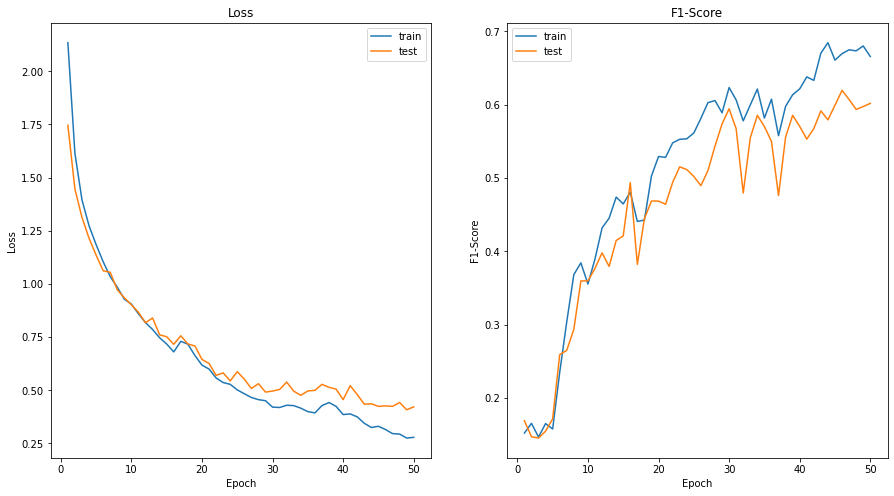

,0,1,2,3,4,5,6,7,8,9,10
0,13,1,3,0,0,0,0,0,0,0,0
1,0,66,0,0,0,0,0,0,0,1,0
2,2,0,6,0,0,0,2,0,0,0,0
3,0,2,0,129,3,2,0,1,0,0,0
4,0,0,0,8,37,14,0,2,0,0,0
5,0,0,0,0,1,28,1,1,0,0,0
6,0,0,1,0,0,0,5,1,0,0,0
7,0,0,0,0,0,1,1,6,1,0,0
8,0,1,0,0,2,0,0,1,1,0,0
9,0,1,0,0,0,0,0,1,0,3,0


OOF-3| Epoch:  10| Train loss: 0.91430| Train F1: 0.36233| Test loss: 0.89810| Test F1: 0.37874
OOF-3| Epoch:  20| Train loss: 0.64071| Train F1: 0.50909| Test loss: 0.63711| Test F1: 0.47294
OOF-3| Epoch:  30| Train loss: 0.43519| Train F1: 0.62726| Test loss: 0.48531| Test F1: 0.58788
OOF-3| Epoch:  40| Train loss: 0.34582| Train F1: 0.66624| Test loss: 0.44628| Test F1: 0.61605
OOF-3| Epoch:  50| Train loss: 0.27381| Train F1: 0.69924| Test loss: 0.39409| Test F1: 0.61176
BEST| OOF-3| Epoch:  49| Train loss: 0.30080| Train F1: 0.67156| Test loss: 0.37631| Test F1: 0.64046


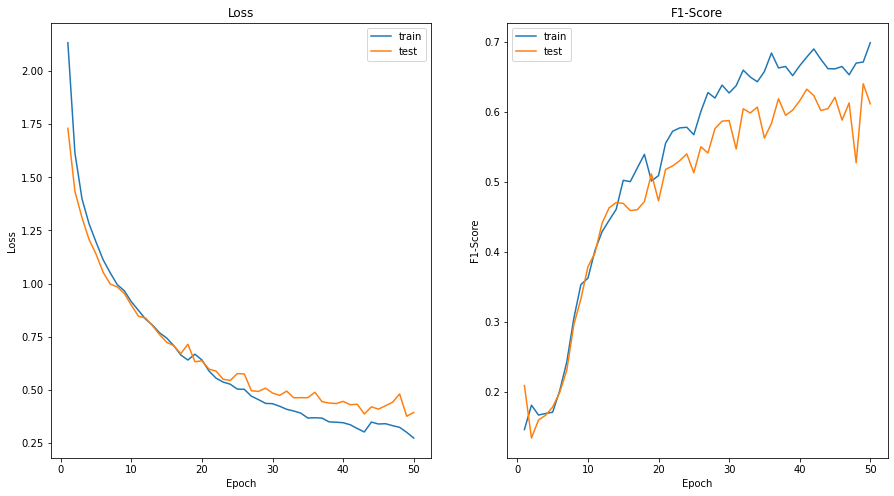

,0,1,2,3,4,5,6,7,8,9,10
0,15,1,1,0,0,0,0,0,0,0,0
1,0,64,0,0,1,1,0,0,0,1,0
2,1,0,7,0,0,0,2,0,0,0,0
3,0,0,0,133,3,1,0,0,0,0,0
4,0,0,0,8,50,3,0,1,0,0,0
5,0,0,1,1,1,27,0,0,0,0,0
6,0,0,2,0,0,0,6,0,0,0,0
7,0,1,0,0,0,0,0,7,0,1,0
8,0,0,0,0,0,0,0,5,0,0,0
9,0,1,0,0,1,0,0,0,0,2,0


OOF-4| Epoch:  10| Train loss: 0.90912| Train F1: 0.37267| Test loss: 0.91155| Test F1: 0.41226
OOF-4| Epoch:  20| Train loss: 0.59681| Train F1: 0.53702| Test loss: 0.65888| Test F1: 0.50569
OOF-4| Epoch:  30| Train loss: 0.55928| Train F1: 0.57829| Test loss: 0.60550| Test F1: 0.55578
OOF-4| Epoch:  40| Train loss: 0.33432| Train F1: 0.68185| Test loss: 0.43104| Test F1: 0.59239
OOF-4| Epoch:  50| Train loss: 0.27571| Train F1: 0.69169| Test loss: 0.39377| Test F1: 0.62485
BEST| OOF-4| Epoch:  41| Train loss: 0.34773| Train F1: 0.68325| Test loss: 0.42052| Test F1: 0.66120


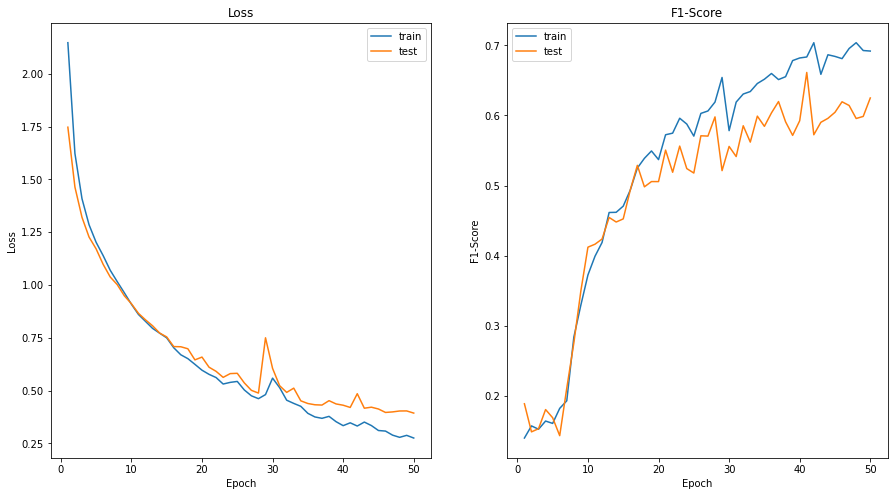

,0,1,2,3,4,5,6,7,8,9,10
0,14,0,3,0,0,0,0,0,0,0,0
1,0,63,0,1,1,1,0,0,0,1,0
2,1,0,7,0,0,0,2,0,0,0,0
3,0,1,0,126,7,1,0,0,0,2,0
4,0,0,0,5,53,2,0,2,0,0,0
5,0,0,0,1,2,26,0,1,0,0,0
6,0,0,0,0,0,0,6,1,0,0,0
7,0,0,0,0,0,0,1,8,0,1,0
8,0,1,0,0,0,0,0,2,1,0,0
9,0,0,0,1,1,0,1,0,0,2,0


In [20]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=config.oof, random_state=22, shuffle=True)

y_true_list = []
y_pred_list = []

for oof, (trn_idx, val_idx) in enumerate(kfold.split(dataset1_train_df, dataset1_train_df['class'])):

        dataset1_trn_df = dataset1_train_df.iloc[trn_idx, :].reset_index(drop = True)
        dataset1_val_df = dataset1_train_df.iloc[val_idx, :].reset_index(drop = True)

        seed_everything(22)

        dataset1_train_df_dataset = CustomDataset(dataset1_trn_df)
        dataset1_train_df_data_loader = DataLoader(
                dataset1_train_df_dataset,
                batch_size = config.batch_size,
                shuffle = True, 
                drop_last = False,
                collate_fn = make_collate_fn,
                num_workers = config.num_workers)

        dataset1_test_df_dataset = CustomDataset(dataset1_val_df)
        dataset1_test_df_data_loader = DataLoader(
                dataset1_test_df_dataset,
                batch_size = config.batch_size,
                shuffle = False, 
                drop_last = False,
                collate_fn = make_collate_fn,
                num_workers = config.num_workers)

        model = TrasformerEncoderLSTM(
                num_cols = config.num_cols, 
                num_labels = config.dataset0_num_labels, 
                hidden_units = config.hidden_units, 
                num_heads = config.num_heads, 
                num_layers = config.num_layers, 
                dropout_rate = config.dropout_rate,).to(config.device)

        model.load_state_dict(torch.load(os.path.join(config.model_dir, config.dataset0_model_name + '.pt')))

        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, config.dataset1_num_labels).to(config.device)

        optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
        criterion = nn.CrossEntropyLoss()

        best_test_fi = 0
        train_loss_list, test_loss_list, train_fi_list, test_fi_list = [], [], [], []

        for epoch in range(1, config.epochs + 1):
                
                train_loss, train_fi = train(model, dataset1_train_df_data_loader, criterion, optimizer, config)
                test_loss, test_fi = evaluate(model, dataset1_test_df_data_loader, criterion, config)

                train_loss_list += [train_loss]
                train_fi_list += [train_fi]

                test_loss_list += [test_loss]
                test_fi_list += [test_fi]

                if best_test_fi < test_fi:
                        best_epoch, best_train_loss, best_train_fi, best_test_loss, best_test_fi = epoch, train_loss, train_fi, test_loss, test_fi
                        torch.save(model.state_dict(), os.path.join(config.model_dir, f'OOF-{oof}-' + config.dataset1_model_name + '.pt'))
                
                if epoch % 10 == 0:
                        print(f'OOF-{oof}| Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| Train F1: {train_fi:.5f}| Test loss: {test_loss:.5f}| Test F1: {test_fi:.5f}')
                
        print(f'BEST| OOF-{oof}| Epoch: {best_epoch:3d}| Train loss: {best_train_loss:.5f}| Train F1: {best_train_fi:.5f}| Test loss: {best_test_loss:.5f}| Test F1: {best_test_fi:.5f}')

        model.load_state_dict(torch.load(os.path.join(config.model_dir, f'OOF-{oof}-' + config.dataset1_model_name + '.pt')))
        
        y_true = dataset1_val_df['class'].tolist()
        y_pred = predict(model, dataset1_test_df_data_loader)
        
        y_true_list += y_true
        y_pred_list += y_pred

        show_train_imgae(train_loss_list, test_loss_list, train_fi_list, test_fi_list, config)
        show_confusion_matrix(y_true, y_pred)

In [21]:
show_confusion_matrix(y_true_list, y_pred_list)

,0,1,2,3,4,5,6,7,8,9,10
0,76,2,7,0,0,0,0,0,0,0,0
1,0,319,0,5,2,2,0,0,0,5,0
2,8,0,34,0,0,0,7,0,0,0,0
3,0,4,0,643,31,5,0,1,0,2,0
4,0,0,0,34,244,23,0,6,0,0,0
5,0,0,1,5,9,134,1,2,0,0,0
6,1,1,3,0,0,0,28,3,0,0,0
7,0,2,0,1,2,1,3,36,1,2,0
8,0,2,0,1,2,0,1,16,2,0,0
9,0,2,1,5,2,0,1,1,0,12,0


### 추론

In [22]:
model = TrasformerEncoderLSTM(
    num_cols = config.num_cols, 
    num_labels = config.dataset1_num_labels, 
    hidden_units = config.hidden_units, 
    num_heads = config.num_heads, 
    num_layers = config.num_layers, 
    dropout_rate = config.dropout_rate,
    ).to(config.device)

dataset1_test_df_dataset = CustomDataset(dataset1_test_df)
dataset1_test_df_data_loader = DataLoader(
        dataset1_test_df_dataset,
        batch_size = config.batch_size,
        shuffle = False, 
        drop_last = False,
        collate_fn = make_collate_fn,
        num_workers = config.num_workers)

y_pred_list = []
for oof in range(config.oof):
    model.load_state_dict(torch.load(os.path.join(config.model_dir, f'OOF-{oof}-' + config.dataset1_model_name + '.pt')))
    y_pred = oof_predict(model, dataset1_test_df_data_loader)
    y_pred_list.append(y_pred)

y_pred = np.mean(y_pred_list, axis = 0).argmax(axis = 1)

In [23]:
submission = pd.DataFrame(y_pred, columns=['predicted value'])
submission['predicted value'] = 'class' + submission['predicted value'].astype(str)
submission.index = dataset1_test_df['index'].values
submission.to_csv('OOF-'+ config.submission_file_name + '.csv')
submission.head()

,predicted value
9,class2
38,class3
46,class7
65,class7
79,class0


## Out-of-Fold Ensemble 적용 X

### 학습

In [24]:
from sklearn.model_selection import train_test_split

dataset1_trn_df, dataset1_val_df = train_test_split(dataset1_train_df, test_size = 0.2, random_state=22, shuffle=True, stratify = dataset1_train_df['class'])
dataset1_trn_df = dataset1_trn_df.reset_index(drop = True)
dataset1_val_df = dataset1_val_df.reset_index(drop = True)

In [25]:
seed_everything(22)

In [26]:
dataset1_train_df_dataset = CustomDataset(dataset1_trn_df)
dataset1_train_df_data_loader = DataLoader(
        dataset1_train_df_dataset,
        batch_size = config.batch_size,
        shuffle = True, 
        drop_last = False,
        collate_fn = make_collate_fn,
        num_workers = config.num_workers)


dataset1_test_df_dataset = CustomDataset(dataset1_val_df)
dataset1_test_df_data_loader = DataLoader(
        dataset1_test_df_dataset,
        batch_size = config.batch_size,
        shuffle = False, 
        drop_last = False,
        collate_fn = make_collate_fn,
        num_workers = config.num_workers)

In [27]:
model = TrasformerEncoderLSTM(
    num_cols = config.num_cols, 
    num_labels = config.dataset0_num_labels, 
    hidden_units = config.hidden_units, 
    num_heads = config.num_heads, 
    num_layers = config.num_layers, 
    dropout_rate = config.dropout_rate,
    ).to(config.device)

model.load_state_dict(torch.load(os.path.join(config.model_dir, config.dataset0_model_name + '.pt')))

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, config.dataset1_num_labels).to(config.device)

optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
criterion = nn.CrossEntropyLoss()

In [28]:
best_test_fi = 0
train_loss_list, test_loss_list, train_fi_list, test_fi_list = [], [], [], []

for epoch in range(1, config.epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
            train_loss, train_fi = train(model, dataset1_train_df_data_loader, criterion, optimizer, config)
            test_loss, test_fi = evaluate(model, dataset1_test_df_data_loader, criterion, config)

            train_loss_list += [train_loss]
            train_fi_list += [train_fi]

            test_loss_list += [test_loss]
            test_fi_list += [test_fi]

            if best_test_fi < test_fi:
                best_epoch, best_train_loss, best_train_fi, best_test_loss, best_test_fi = epoch, train_loss, train_fi, test_loss, test_fi
                torch.save(model.state_dict(), os.path.join(config.model_dir, config.dataset1_model_name + '.pt'))

            tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| Train F1: {train_fi:.5f}| Test loss: {test_loss:.5f}| Test F1: {test_fi:.5f}')
    
print(f'BEST | Epoch: {best_epoch:3d}| Train loss: {best_train_loss:.5f}| Train F1: {best_train_fi:.5f}| Test loss: {best_test_loss:.5f}| Test F1: {best_test_fi:.5f}')

Epoch:   1| Train loss: 2.11498| Train F1: 0.15006| Test loss: 1.72997| Test F1: 0.20805: 100%|██████████| 1/1 [00:05<00:00,  5.18s/it]
Epoch:   2| Train loss: 1.59774| Train F1: 0.17023| Test loss: 1.44212| Test F1: 0.15463: 100%|██████████| 1/1 [00:05<00:00,  5.03s/it]
Epoch:   3| Train loss: 1.39963| Train F1: 0.16240| Test loss: 1.30074| Test F1: 0.16852: 100%|██████████| 1/1 [00:04<00:00,  4.98s/it]
Epoch:   4| Train loss: 1.27966| Train F1: 0.16750| Test loss: 1.19150| Test F1: 0.15786: 100%|██████████| 1/1 [00:05<00:00,  5.32s/it]
Epoch:   5| Train loss: 1.19146| Train F1: 0.17419| Test loss: 1.11385| Test F1: 0.18580: 100%|██████████| 1/1 [00:04<00:00,  4.98s/it]
Epoch:   6| Train loss: 1.11091| Train F1: 0.21896| Test loss: 1.04946| Test F1: 0.24167: 100%|██████████| 1/1 [00:05<00:00,  5.02s/it]
Epoch:   7| Train loss: 1.04529| Train F1: 0.28900| Test loss: 0.97499| Test F1: 0.28942: 100%|██████████| 1/1 [00:05<00:00,  5.04s/it]
Epoch:   8| Train loss: 1.00348| Train F1: 0.349

BEST | Epoch:  37| Train loss: 0.35745| Train F1: 0.65972| Test loss: 0.34299| Test F1: 0.68319


```

BEST | Epoch:  28| Train loss: 0.82840| Train F1: 0.40119| Test loss: 0.82462| Test F1: 0.39522 - non 퓨리에 변환 / class spli

BEST | Epoch:  49| Train loss: 0.38935| Train F1: 0.65121| Test loss: 0.41082| Test F1: 0.63645 - add 퓨리에 변환 / class split

BEST | Epoch:  32| Train loss: 0.53002| Train F1: 0.60324| Test loss: 0.56839| Test F1: 0.62315 - add 퓨리에 변환 / split_val spli

BEST | Epoch:  42| Train loss: 0.17065| Train F1: 0.80538| Test loss: 0.24134| Test F1: 0.76476 - add 퓨리에 변환 / diff 변수 / class split

```

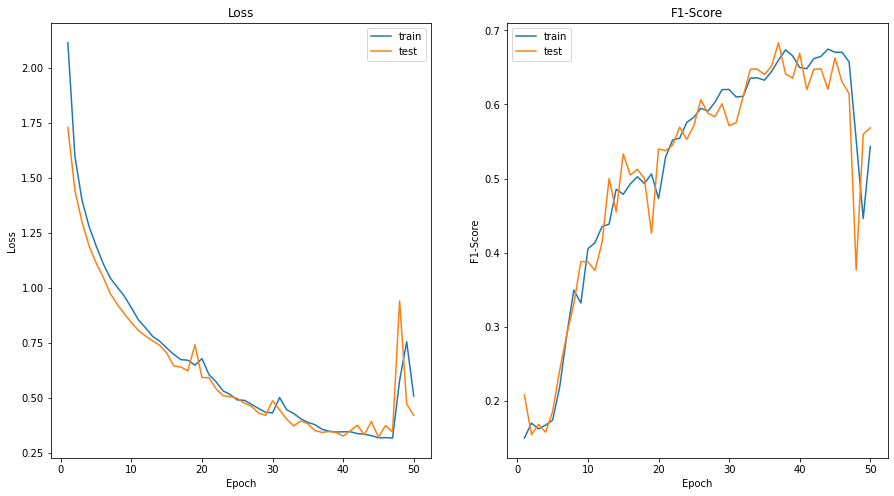

,0,1,2,3,4,5,6,7,8,9,10
0,16,0,1,0,0,0,0,0,0,0,0
1,0,63,1,1,0,0,0,0,0,2,0
2,2,0,7,0,0,0,1,0,0,0,0
3,0,0,0,131,4,2,0,0,0,0,0
4,0,0,0,3,54,4,0,0,0,0,0
5,0,0,0,1,3,26,0,0,0,0,0
6,0,0,0,0,0,0,7,0,0,0,0
7,0,0,0,0,1,0,0,9,0,0,0
8,0,0,0,0,0,0,0,5,0,0,0
9,0,1,0,0,0,0,0,1,0,3,0


In [29]:
model = TrasformerEncoderLSTM(
    num_cols = config.num_cols, 
    num_labels = config.dataset1_num_labels, 
    hidden_units = config.hidden_units, 
    num_heads = config.num_heads, 
    num_layers = config.num_layers, 
    dropout_rate = config.dropout_rate,
    ).to(config.device)
    
model.load_state_dict(torch.load(os.path.join(config.model_dir, config.dataset1_model_name + '.pt')))

y_true = dataset1_val_df['class'].tolist()
y_pred = predict(model, dataset1_test_df_data_loader)

show_train_imgae(train_loss_list, test_loss_list, train_fi_list, test_fi_list, config)
show_confusion_matrix(y_true, y_pred)

### 추론

In [30]:
model = TrasformerEncoderLSTM(
    num_cols = config.num_cols, 
    num_labels = config.dataset1_num_labels, 
    hidden_units = config.hidden_units, 
    num_heads = config.num_heads, 
    num_layers = config.num_layers, 
    dropout_rate = config.dropout_rate,
    ).to(config.device)

model.load_state_dict(torch.load(os.path.join(config.model_dir, config.dataset1_model_name + '.pt')))

dataset1_test_df_dataset = CustomDataset(dataset1_test_df)
dataset1_test_df_data_loader = DataLoader(
        dataset1_test_df_dataset,
        batch_size = config.batch_size,
        shuffle = False, 
        drop_last = False,
        collate_fn = make_collate_fn,
        num_workers = config.num_workers)

y_pred = predict(model, dataset1_test_df_data_loader)

In [31]:
submission = pd.DataFrame(y_pred, columns=['predicted value'])
submission['predicted value'] = 'class' + submission['predicted value'].astype(str)
submission.index = dataset1_test_df['index'].values
submission.to_csv(config.submission_file_name + '.csv')
submission.head()

,predicted value
9,class2
38,class9
46,class7
65,class7
79,class0
